# Rosenbrock toy distribution

This function (further described [here](http://pints.readthedocs.io/en/latest/toy/rosenbrock.html)) which can be used to define a normalisable probability density function:

$ p(x, y) \propto  \frac{1}{1 + \text{RosenbrockError}(x,y)}, $

that is,

$ p(x, y) \propto  \frac{1}{\left(1 + (1 - x)^2 + 100 (y - x^2)^2) \right)}, $

which we term the `RosenbrockLogPDF`.

We now plot this function.

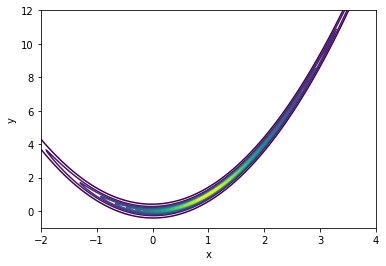

In [1]:
from __future__ import print_function
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import pints.plot

# Create Rosenbrock log pdf
log_pdf = pints.toy.RosenbrockLogPDF()

# Contour plot of pdf
levels = np.linspace(0, 1, 20)
x = np.linspace(-2, 4, 400)
y = np.linspace(-1, 12, 400)
X, Y = np.meshgrid(x, y)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, levels = levels)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Turn into Bayesian problem by using the inverse Rosenbrock function as a likelihood

Then use Hamiltonian Monte Carlo to sample from the posterior distribution

In [2]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([1, 1], [1.1, 1.1], size=(4, 2))
sigma0 = [0.5, 0.5]

# Use suggested prior bounds
bounds = log_pdf.suggested_bounds()

# Create a uniform prior over both the parameters
log_prior = pints.UniformLogPrior(
    bounds[0], bounds[1]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_pdf, log_prior)

mcmc = pints.MCMCController(log_posterior, 4, x0, method=pints.HamiltonianMCMC, sigma0=sigma0)

# Stop after 8000 iterations
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')


# Discard warm-up
chains = [chain[1000:] for chain in chains]

print('R-hat:')
print(pints.rhat_all_params(chains))

Running...
Done!
R-hat:
[1.052209468297751, 1.0588502434451224]


We inspect the results by creating a scatter plot of the samples. Hamiltonian Monte Carlo does pretty well although struggles to sample from the thin tails

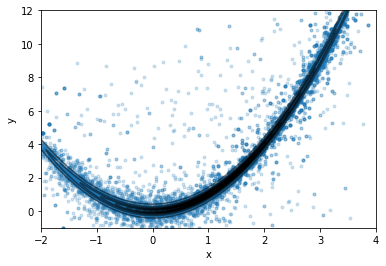

In [3]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Plot the path of one of the chains

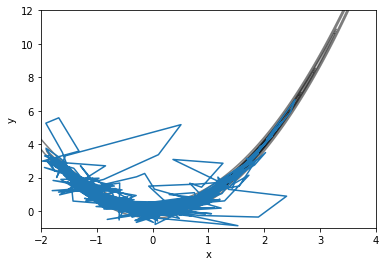

In [4]:
plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.5)
plt.plot(chain[0:1000,0], chain[0:1000,1])
plt.xlim(-2, 4)
plt.ylim(-1, 12)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Calculate normed distance of sample mean and sample covariance from true values

In [5]:
print('Normed distance = ' + str(log_pdf.distance(stacked)))

Normed distance = 3.76987891386
